### Домашнее задание Transformers Training (50 баллов)

В этом домашнем задании требуется обучить несколько Transformer-based моделей в задаче машинного перевода. Для обучения можно воспользоваться текущим проектом, так и реализовать свой пайплайн обучения. Если будете использовать проект, теги **TODO** проекта отмечают, какие компоненты надо реализовать.
В ноутбуке нужно только отобразить результаты обучения и выводы. Архитектура модели(количетсво слоев, размерность и тд) остается на ваш выбор.

Ваш код обучения нужно выложить на ваш github, в строке ниже дать ссылку на него. В первую очередь будут оцениваться результаты в ноутбуке, код нужен для проверки адекватности результатов. 

Обучать модели до конца не нужно, только для демонстрации, что модель обучается и рабочая - снижение val_loss, рост bleu_score.

#### Сcылка на ваш github с проектом(вставить свой) - https://github.com/runnerup96/pytorch-machine-translation

Ноутбук с результатами выкладывать на ваш **google диск** курса. 

### Данные

`
wget https://www.manythings.org/anki/rus-eng.zip && unzip rus-eng.zip
`

Модели нужно обучить на задаче перевода с английского на русский. 

In [1]:
!unzip /content/Archive.zip

Archive:  /content/Archive.zip
  inflating: __init__.py             
   creating: configs/
   creating: configs/.ipynb_checkpoints/
  inflating: configs/model_config.yaml  
  inflating: configs/data_config.yaml  
  inflating: configs/.ipynb_checkpoints/model_config-checkpoint.yaml  
  inflating: configs/.ipynb_checkpoints/data_config-checkpoint.yaml  
   creating: dataset/
  inflating: dataset/rus.txt         
  inflating: __MACOSX/dataset/._rus.txt  
   creating: dataset/.ipynb_checkpoints/
  inflating: dataset/.ipynb_checkpoints/rus-checkpoint.txt  
  inflating: __MACOSX/dataset/.ipynb_checkpoints/._rus-checkpoint.txt  
   creating: src/
  inflating: src/metrics.py          
  inflating: src/txt_logger.py       
 extracting: src/__init__.py         
   creating: src/models/
   creating: src/__pycache__/
   creating: src/data/
  inflating: src/models/attention.py  
  inflating: src/models/seq2seq_t5.py  
  inflating: src/models/encoder_rnn.py  
   creating: src/models/__pycache__/
  i

### Обучение Seq2seq Transformer модель(25 баллов)

Реализуйте Seq2seq Transformer. В качестве блока трансформера можно использовать https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html. В качестве токенизатора воспользуйтесь HuggingFace токенизатор для source/target языков - https://huggingface.co/docs/transformers/fast_tokenizers
В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов. 

Не забудьте остальные элементы модели:
* Мы можем использовать 1 трансформер как энкодер - декодером будет выступать линейный слой. 
* Обучите свой BPE токенизатор - https://huggingface.co/docs/transformers/fast_tokenizers
* Матрицу эмбеддингов токенов
* Матрицу позицонных эмбеддингов
* Линейный слой проекции в target словарь
* Функцию маскирования будущих состояний attention, так как модель авто-регрессионна
* Learning rate schedualer


В качестве результатов, приложите слудующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, размерность скрытого слоя, количетсво слоев
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

In [1]:
!pip3 install tokenizers transformers
import torch
import yaml

from src.data import datamodule
from src.models import seq2seq_transformer, trainer
from src.txt_logger import TXTLogger

if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

data_config = yaml.load(open("configs/data_config.yaml", "r"), Loader=yaml.Loader)
dm = datamodule.DataManager(data_config, DEVICE)
train_dataloader, dev_dataloader = dm.prepare_data()

model_config = yaml.load(open("configs/model_config.yaml", "r"), Loader=yaml.Loader)

# TODO: Инициализируйте модель Seq2SeqTransformer
model = seq2seq_transformer.Seq2SeqTransformer(
    device=DEVICE,
    emb_size=model_config["emb_size"],
    vocab_size=len(dm.target_tokenizer),
    nhead=model_config["nhead"],
    num_layers=model_config["num_layers"],
    dim_feedforward=model_config["dim_feedforward"],
    target_tokenizer=dm.target_tokenizer,
    max_seq_length=data_config["max_length"] * 10,
).to(DEVICE)

logger = TXTLogger("training_logs")
trainer_cls = trainer.Trainer(model=model, model_config=model_config, logger=logger)

if model_config["try_one_batch"]:
    train_dataloader = [list(train_dataloader)[0]]
    dev_dataloader = [list(train_dataloader)[0]]
trainer_cls.train(train_dataloader, dev_dataloader)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Reading from file: 467119it [00:09, 51882.40it/s]
  0%|          | 1/400 [01:06<7:23:09, 66.64s/it]

Current BLEU:  0.41746427959445975
том и некотор ---> том и ма ого
ты знал что у ---> ты знал что э
ты вроде гово ---> яы дыяде тодо
не понимаю по ---> яе понимаю чо
том планирует ---> том поанирует
##############################


  0%|          | 2/400 [02:12<7:17:40, 65.98s/it]

Current BLEU:  0.40575981160588853
я хочу чтобы ---> я хочу чтобы
мэри нравится ---> мэри зравится
том перевёл с ---> том помемыл п
том так и не ---> том на  и не
видишь большо ---> тыдишь сыльше
##############################


  1%|          | 3/400 [03:17<7:14:59, 65.74s/it]

Current BLEU:  0.48015571176493416
взрыв популяц ---> пеяечаполасит
я сел в кресл ---> я сел весоиме
по правде гов ---> срлтровда сов
я сказал тому ---> я сказал тому
том пытался п ---> том пытался у
##############################


  1%|          | 4/400 [04:23<7:13:16, 65.65s/it]

Current BLEU:  0.5067657583274098
мой отец не т ---> мой отец де с
том пообещал ---> том сообещал
она следит за ---> она пледул ва
если я тебе к ---> если б тебе с
почему вы всё ---> почему ты пст
##############################


  1%|▏         | 5/400 [05:27<7:09:03, 65.17s/it]

Current BLEU:  0.5592574176839393
все мужчины б ---> все можчиныйм
очевидно что ---> эневидно тто
том будет сме ---> том судет с о
я думал я теб ---> я думал ч ноб
ты всегда дол ---> те дсегда дол
##############################


  2%|▏         | 6/400 [06:32<7:06:43, 64.98s/it]

Current BLEU:  0.5328988107448448
он давно им н ---> он новно н ен
пожалуйста за ---> пожалуйста па
мэри посовето ---> тери тосовето
том верит все ---> том всрит все
пока ты не пр ---> воназты пе пр
##############################


  2%|▏         | 7/400 [07:38<7:09:01, 65.50s/it]

Current BLEU:  0.5407348943854802
не забудь что ---> не забудь что
мне больше нр ---> яне ныльше нр
у тома и мэри ---> у тома и мэри
я не хочу гов ---> я не хочу сов
некоторые утв ---> некоторые лгр
##############################


  2%|▏         | 8/400 [08:45<7:10:06, 65.83s/it]

Current BLEU:  0.533188255442983
я уснул заним ---> я ппнул са ум
я нашёл эту э ---> я нашёл пто п
того мальчишк ---> эато бнльчике
эта машина сл ---> это машина сл
пожалуйста по ---> пожалуйста пож
##############################


  2%|▏         | 9/400 [09:49<7:06:56, 65.51s/it]

Current BLEU:  0.5922092303910995
том никогда н ---> том никогда н
том ловил мух ---> том пежал паз
она попросила ---> она попросила
я здесь живу ---> я ждесь живут
том не из тех ---> том не дд даб
##############################


  2%|▎         | 10/400 [10:54<7:03:17, 65.12s/it]

Current BLEU:  0.5596966790895335
ты ненавидишь ---> ты ненавидишь
насколько эфф ---> касколько фтее
мне нужна инф ---> мне нужна внф
жаль что у то ---> эаль что эжэр
город снабжал ---> коряд пточиал
##############################


  3%|▎         | 11/400 [12:00<7:04:22, 65.46s/it]

Current BLEU:  0.580938605119999
я знаю что то ---> я знаю что то
какое грязное ---> оаж ймиоазну
мы посадили в ---> мы плсадили с
я разберусь с ---> я сазрерусь с
что вы любите ---> что ты любите
##############################


  3%|▎         | 12/400 [13:06<7:04:52, 65.70s/it]

Current BLEU:  0.5936985831993897
вы не должны ---> та не должны
проблемы обыч ---> проблема нб ч
том читает кн ---> том читает па
ты будешь чув ---> ты пудешь сув
без кота мыша ---> куз кот  башл
##############################


  3%|▎         | 13/400 [14:14<7:08:01, 66.36s/it]

Current BLEU:  0.5976305676338478
том купил три ---> том купил три
в году испани ---> в пору ггпоте
я хочу чтобы ---> я хочу чтобы
думаешь полиц ---> думаешь полиц
у тебя есть ч ---> т тебя хщть с
##############################


  4%|▎         | 14/400 [15:24<7:13:49, 67.43s/it]

Current BLEU:  0.581679335093604
том пригласил ---> том пригласил
вы когда нибу ---> ты когда нибу
не потеряй во ---> не сомишяй н
хочешь не хоч ---> подешь тр точ
у меня такое ---> у меня еекое
##############################


  4%|▍         | 15/400 [16:30<7:10:40, 67.12s/it]

Current BLEU:  0.6001434770259224
том говорит ч ---> том говорит ч
они послали н ---> они послали н
я не знаю пра ---> я не знаю чоо
ты не должен ---> те не должен
не понимаю за ---> яе понимаю па
##############################


  4%|▍         | 16/400 [17:36<7:06:01, 66.57s/it]

Current BLEU:  0.54119703171849
это заманчиво ---> это ва ениива
я знаю что то ---> я знаю что то
если твои окн ---> если твои окн
моя цель не у ---> моя дель не п
по французски ---> то французски
##############################


  4%|▍         | 17/400 [18:43<7:06:19, 66.79s/it]

Current BLEU:  0.6154737601375877
кем ты хочешь ---> чам ты хочешь
я хочу чтобы ---> я хочу чтобы
на третьем эт ---> еа доебие  ет
думаешь том в ---> думаешь том в
сто долларов ---> отаисолжжлива
##############################


  4%|▍         | 18/400 [19:48<7:01:54, 66.27s/it]

Current BLEU:  0.6228995919316536
организация о ---> нбуа иео ая н
почему ты всё ---> почему ты всё
тебе понравил ---> тебе понравил
зря я пообеща ---> жря я эрззида
том позвал мэ ---> том позвол мэ
##############################


  5%|▍         | 19/400 [20:53<6:59:11, 66.02s/it]

Current BLEU:  0.6090660173777671
ты действител ---> ты пействител
это не должно ---> это не должно
том спрятался ---> том спрятался
если при выдо ---> если тоисты н
том и мэри на ---> том и мэри на
##############################


  5%|▌         | 20/400 [21:58<6:54:52, 65.51s/it]

Current BLEU:  0.5873318240471801
том ничего не ---> том нечего не
том вероятно ---> вом вероятно
самая любимая ---> лемыя тюбима
будем надеять ---> будем надеять
ей не нравятс ---> ей не нравитс
##############################


  5%|▌         | 21/400 [23:05<6:57:56, 66.16s/it]

Current BLEU:  0.5941322691484457
чем старше мы ---> сем старши пе
у меня не оче ---> я меня не оче
я думал тому ---> я думал том 
я не знал что ---> я не знал что
забастовка на ---> за автораа па
##############################


  6%|▌         | 22/400 [24:13<6:59:04, 66.52s/it]

Current BLEU:  0.6322983298973136
я быстро съел ---> я быстро съел
том и мэри ку ---> том и мэри ку
не думаю что ---> не думаю что
том время от ---> том п амя вб
я помню вы го ---> я помню ча тд
##############################


  6%|▌         | 22/400 [24:17<6:57:24, 66.26s/it]

Last 22 epoch train loss:  83.3468209207058
Last 22 epoch val loss:  0.6249455415954193
Last 22 epoch val bleu:  0.6322983298973136


In [45]:
def predict(src):
      model.eval()

      with torch.no_grad():
          src = src.to(model.device)
          trg_input = torch.tensor([[model.target_tokenizer.tokenizer.token_to_id('[BOS]')]], device=model.device)
          output = []

          while trg_input[:, -1].item() != model.target_tokenizer.tokenizer.token_to_id('[EOS]') and len(output) < 34:
              trg_input = trg_input.to(model.device)
              _, output_step = model.forward(src, trg_input)
              pred_token = torch.argmax(output_step, dim=-1)[:, -1]
              output.append(pred_token.item())

              trg_input = torch.cat((trg_input, pred_token.unsqueeze(1)), dim=-1)

          predicted_ids = torch.tensor(output, device=model.device).unsqueeze(0)
            
      model.train()
      return predicted_ids

In [29]:
for i, batch in enumerate(dev_dataloader):
    src, trg = batch

    target_tokens = dm.target_tokenizer.decode(trg[0].tolist())
    source_tokens = dm.source_tokenizer.decode(src[0].tolist())
    predicted_tokens = dm.target_tokenizer.decode(model.predict(src[:1,])[0].tolist())

    print("Source: ", source_tokens, "\tTarget: ", target_tokens, "\tPredicted: ", predicted_tokens)
    if i > 9:
      break

Source:  everything will 	Target:  всё случится 	Predicted:  всё будет с т
Source:  i didn t know tha 	Target:  я не знал что 	Predicted:  я не знал что
Source:  i don t want to tal 	Target:  я не хочу с в 	Predicted:  я не хочу гов
Source:  the government s 	Target:  решение прави 	Predicted:  зовут признач
Source:  you re the most bea 	Target:  ты самая крас 	Predicted:  ты большинств
Source:  puns are very hard 	Target:  игру слов оче 	Predicted:  положи очень
Source:  tom s great great g 	Target:  прапрапрабабу 	Predicted:  жерт тома сов
Source:  why don t you try onth 	Target:  почему ты не 	Predicted:  почему бы теб
Source:  i m not the kind of 	Target:  я не такой ка 	Predicted:  я не добрый д
Source:  tom is going to get m 	Target:  том собираетс 	Predicted:  том собираетс
Source:  this factory man 	Target:  этот завод пр 	Predicted:  этот факт муж


In [43]:
import os
import re
import json
import matplotlib.pylab as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [44]:
MATCH_REGEX = re.compile(r"[+-]?\b(\d+([.]\d*)?([eE][+-]?\d+)?|[.]\d+([eE][+-]?\d+)?)\b")

def extract_values(string):
    result = dict()
    params = ['val_loss', 'train_loss', 'bleu_score']
    if "train_loss" in string:
        found_vals = [re_match[0] for re_match in re.findall(MATCH_REGEX, string)]
    
        if len(params) == len(found_vals):
            for name, val in zip(params, found_vals):
                result[name] = float(val)
    return result

def plot_results(train_loss_list, val_loss_list, val_bleu_list, run_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    
    ax1.plot(range(len(train_loss_list)), train_loss_list, label='train loss')
    ax1.plot(range(len(val_loss_list)), val_loss_list, label='val loss')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.legend()
    
    ax2.plot(range(len(val_bleu_list)), val_bleu_list, label='val bleu')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('BLEU')
    ax2.legend()
    
    fig.suptitle(run_name, fontsize=20)
    plt.show()

In [45]:
DATAPATH = '/content/training_logs'
progress_file_path = os.path.join(DATAPATH, "progress_log.txt")
file_content = open(progress_file_path, 'r').read().split("\n")

In [46]:
train_loss_list, val_loss_list, val_bleu_list = [], [], []
for line in file_content:
    d = extract_values(line)
    if len(d) > 0:
        train_loss_list.append(d['train_loss'])
        val_loss_list.append(d['val_loss'])
        val_bleu_list.append(d['bleu_score'])
    
        
len(train_loss_list), len(val_loss_list), len(val_bleu_list)

(10, 10, 10)

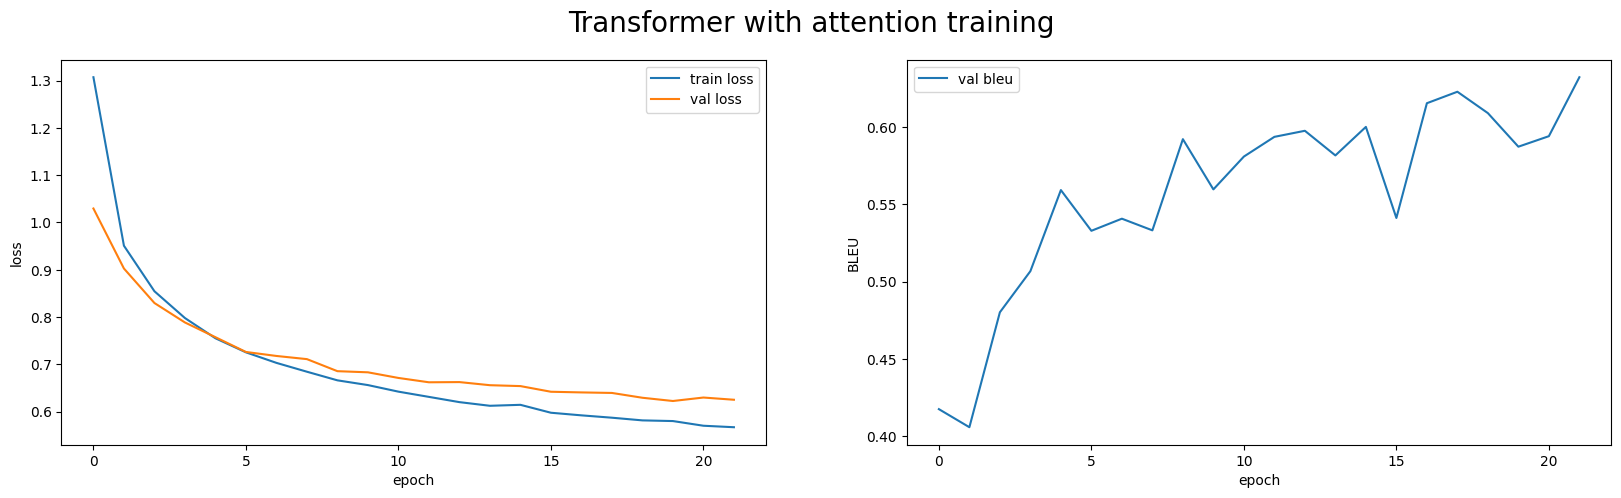

In [35]:
plot_results(train_loss_list, val_loss_list, val_bleu_list, run_name='Transformer with attention training')

### Fine-tune pretrained T5 (25 баллов)

Реализуйте Seq2seq Pretrained T5. Воспользуйтесь https://huggingface.co/docs/transformers/model_doc/t5 предобученной моделью. В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов. Архитектура модели(количетсво слоев, размерность и тд) остается на ваш выбор.

Не забудьте важные аспекты обучения модели:
* Взять готовый t5 токенизатор
* Resize matrix embedding - скорей всего ваша матрица эмбеддингов не будет включать эмбеддинги из вашего сета. Пример обновления матрицы эмбеддингов тут тут https://github.com/runnerup96/Transformers-Tuning/blob/main/t5_encoder_decoder.py
* Learning rate schedualer/Adafactor with constant learning rate


В качестве результатов, приложите слудующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, pretrained model name
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

In [1]:
!unzip /content/Archive\ 2.zip

Archive:  /content/Archive 2.zip
   creating: configs/
   creating: configs/.ipynb_checkpoints/
  inflating: configs/model_config.yaml  
  inflating: configs/data_config.yaml  
  inflating: configs/.ipynb_checkpoints/model_config-checkpoint.yaml  
  inflating: configs/.ipynb_checkpoints/data_config-checkpoint.yaml  
   creating: dataset/
  inflating: dataset/rus.txt         
  inflating: __MACOSX/dataset/._rus.txt  
   creating: dataset/.ipynb_checkpoints/
  inflating: dataset/.ipynb_checkpoints/rus-checkpoint.txt  
  inflating: __MACOSX/dataset/.ipynb_checkpoints/._rus-checkpoint.txt  
   creating: src/
  inflating: src/metrics.py          
  inflating: src/.DS_Store           
  inflating: __MACOSX/src/._.DS_Store  
  inflating: src/txt_logger.py       
 extracting: src/__init__.py         
   creating: src/models/
   creating: src/__pycache__/
   creating: src/data/
  inflating: src/models/attention.py  
  inflating: src/models/seq2seq_t5.py  
  inflating: src/models/encoder_rnn.py 

In [1]:
!pip3 install tokenizers transformers
import torch
import yaml

from src.data.datamodule import DataManager
from src.models import seq2seq_t5, trainer
from src.txt_logger import TXTLogger

if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

data_config = yaml.load(open("configs/data_config.yaml", "r"), Loader=yaml.Loader)
dm = DataManager(data_config, DEVICE)
train_dataloader, dev_dataloader = dm.prepare_data()

model_config = yaml.load(open("configs/model_config.yaml", "r"), Loader=yaml.Loader)

# TODO: Инициализируйте модель Seq2SeqTransformer
model = seq2seq_t5.Seq2SeqT5(device=DEVICE, tokenizer=dm.global_tokenizer)

logger = TXTLogger("training_logs")
trainer_cls = trainer.Trainer(model=model, model_config=model_config, logger=logger)

# if model_config["try_one_batch"]:
#     train_dataloader = [list(train_dataloader)[0]]
#     dev_dataloader = [list(train_dataloader)[0]]

trainer_cls.train(train_dataloader, dev_dataloader)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Reading from file: 467119it [00:06, 70123.22it/s]
  0%|          | 1/400 [02:43<18:05:31, 163.24s/it]

Current BLEU:  0.2528400591883239
её б аб уш ка д  ---> его поыуш оде а  
её  роман бы л п  ---> его по ишше   ли  
том  и мэ ри п ровели н ---> том  и мэ ри  риётил
не за сиж ивай ся   ---> не   стл илть я  
мы в се  делали что то за ---> мы  се  нлаемсто   
##############################


  0%|          | 2/400 [05:25<17:58:33, 162.60s/it]

Current BLEU:  0.4197615679494615
з имой  ког да м о ---> в ушй  ког да  о
не  думаю что том з  ---> не  думаю что том з 
я  не  в том по лож ении ч --->  не  ы  мож ий 
как  толь ко в  ко ---> томскок томугоь ко ы ра
ж аль что я  родился  ---> хо аль что я  родился 
##############################


  1%|          | 3/400 [08:07<17:55:54, 162.60s/it]

Current BLEU:  0.49314808198980864
ты  разго варивал в о ---> ты горазго варивал в а
том о каза лся  точ но ---> том в тза лся  тол но
том не бы л з десь с о ---> том бы л з десь  
в б ольш ое  дерево на --->   ольш ие  тлав 
у том а в овсе  не б ---> у том а не ыесеё не б
##############################


  1%|          | 4/400 [10:50<17:52:37, 162.52s/it]

Current BLEU:  0.5592029338887654
я  не з нал что  вы с том ---> я  не з нал что тыы  том
снач ала о н сч итал ---> вч ала д н по  иал
ты с об ираешь ся ч ---> ты  таб ираешь ся  
я  не  верю в то что  у ---> я  не  верю ч  томто тому
мы бы ли н еспо соб  ---> мы не ы ли не  епо б 
##############################


  1%|▏         | 5/400 [13:34<17:53:04, 163.00s/it]

Current BLEU:  0.5793659837756265
это  конец том у м иру  ---> это  коточ  а  олоет
том по об ещ ал мэ ри ---> том о об ещ ал мэ ри
на б ерег у  реки м ---> мм олзз ал уш 
я  не  думаю что том з --->  не  думаю что том з
она  люб ит э того ---> она  люб ит м той
##############################


  2%|▏         | 6/400 [16:16<17:48:55, 162.78s/it]

Current BLEU:  0.6316324516293275
мой б рат  интересу ---> мой б рат  интересу
неваж но с луч итс ---> неваж но  луч ас
том с ейч ас в скапы ---> том  койч ас  ёза 
том не  люб ит го ворить ---> том не  люб ит го ворить
зач ем ты  раскры  ---> поч ем    узсры 
##############################


  2%|▏         | 7/400 [18:59<17:45:51, 162.73s/it]

Current BLEU:  0.6292852309547702
мы нач нем за втра  ---> мы нач нм за втра на
том вы рос в н еб оль ---> том вы рос в н еб оль
коралловый  риф г ---> корепьь й  кос  
том в ообще  не  уч ---> том в ссеобще  не  уч
нам н уж но с делать ---> нам н уж но по делать
##############################


  2%|▏         | 8/400 [21:41<17:42:52, 162.68s/it]

Current BLEU:  0.6466598962117005
это  не  мой з онтик ---> это  не  мой з онтик
ты го воришь м не что  ---> ты го воришь ч не что 
если ты хоч ешь   ---> если хо хоч ешь ч 
вы бы по смотрели  как ---> ы ды  слотрели  как
п равитель ство с тим ---> п равитель ство на наора
##############################


  2%|▏         | 9/400 [24:24<17:39:41, 162.61s/it]

Current BLEU:  0.6497509096720506
тот б ар о дно  и ---> этот б ар о динй и
ты д олж ен выб ирать ---> ты д олж ен выб рарать
сроч но н уж ны д  ---> роч но н уж ноы  
бы ло  темно  и я  ---> ы ло  темно  и я 
не  думаю что  у том  ---> не  думаю что  у том 
##############################


  2%|▎         | 10/400 [27:06<17:36:49, 162.59s/it]

Current BLEU:  0.6435100418556753
у м еня  нет выб о ---> у м еня  нет выб ор
во в ремя ч тения п  ---> ко с ременя   иение п 
кораб ль  тщ ате ---> кораб ль б ися ате
том  люб ил мэ ри н ---> том  раюб ил мэ ри н
я хоч у з нать  ког ---> я хоч у з нать  ког
##############################


  2%|▎         | 10/400 [28:37<18:36:18, 171.74s/it]

Last 10 epoch train loss:  135.2405546605587
Last 10 epoch val loss:  0.6563982531428337
Last 10 epoch val bleu:  0.6435100418556753


In [41]:


model.to('cpu')
# # generate text until the output length (which includes the context length) reaches 50
# greedy_output = model.t5_model.generate(torch.IntTensor([input_ids["input_ids"], input_ids["attention_mask"]]), max_length=50)

# print(dm.global_tokenizer.decode(greedy_output[0]))
for i, batch in enumerate(dev_dataloader):
  model.eval()
  with torch.no_grad():
    src, trg, src_mask = batch
    # encode context the generation is conditioned on

    greedy_output = model.t5_model.generate(torch.IntTensor([src[0].tolist(), src_mask[0].tolist()]), max_length=50)
    target_tokens = dm.global_tokenizer.decode(trg[0].tolist())
    source_tokens = dm.global_tokenizer.decode(src[0].tolist())
    predicted_tokens = dm.global_tokenizer.decode(greedy_output[0])

    print("Source: ", source_tokens, "\nTarget: ", target_tokens, "\nPredicted: ", predicted_tokens, "\n\n")
    if i > 9:
      break

Source:  i  ve  been  in  love  with tom  
Target:  я  влюб лена в том а с  
Predicted:  я  влюб ился  в том а 


Source:  i  thought  that you d  be  c 
Target:  я по думал что  вам з 
Predicted:  я  думал ты п ридёш 


Source:  this  year i  don t wa nt  t 
Target:  в этом го ду я  не хо 
Predicted:  в этом го ду я  не хо 


Source:  tom  doesn t wa nt  the  same  
Target:  том не хоч ет ч тобы з  
Predicted:  том не хоч ет то же  самое 


Source:  tom  often  sits  in  front  of  h 
Target:  том ч асто  сидит за с  
Predicted:  том ч асто  сидит в о д 


Source:  how  much is tom  going to  be  paid  
Target:  сколь ко том у за это за 
Predicted:  сколь ко том а б удет 


Source:  i d  like  to  get  married  
Target:  я хо тел бы ж енить ся  
Predicted:  я хо тел бы пож енить ся  


Source:  i  have a  lot  of th ings  t 
Target:  я  долж ен м ногое  сде 
Predicted:  у м еня  много ч его 


Source:  tom  told  me  that i  shouldn t  
Target:  том с каза л м не что   
Predicted:  то

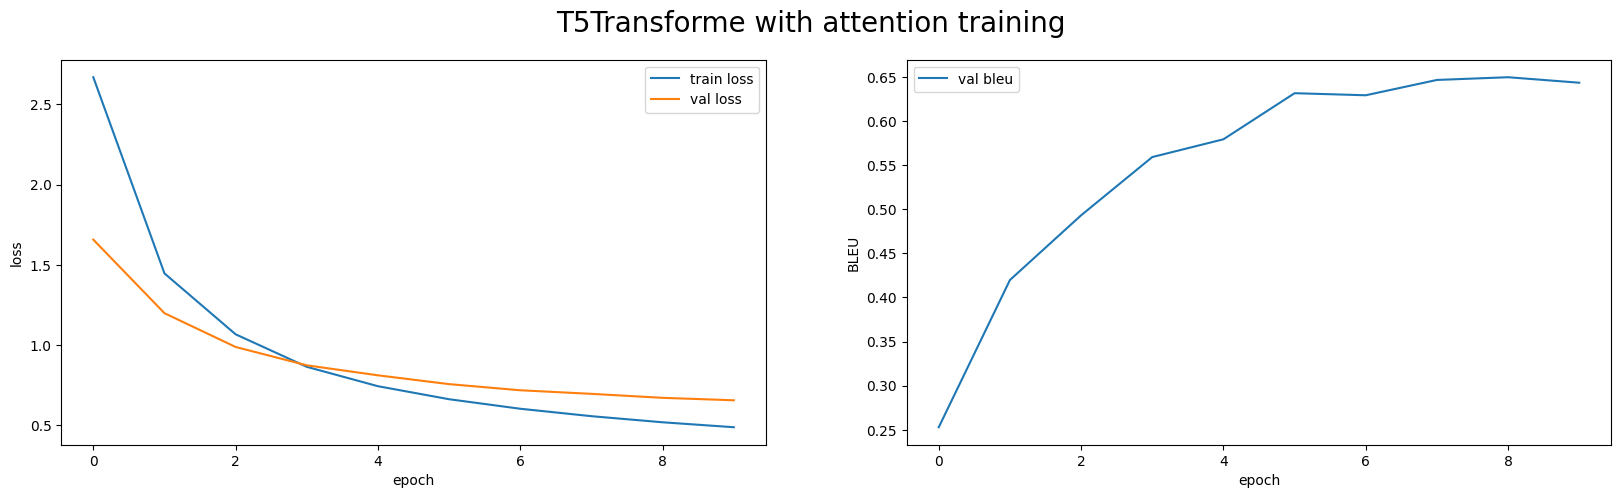

In [48]:
plot_results(train_loss_list, val_loss_list, val_bleu_list, run_name='T5Transforme with attention training')